# Lecture 3
# A Partial-equilibrium Life-cycle Model with Income Risk

* First, we formulate and solve a dynamic life-cycle model with income risk using dynamic programming methods
    * At any point in time, we want to elicit policy functions (optimal current consumption given every possible current state).
    * This requires knowledge about future policy functions.
    * These can be obtained recursively by "backward induction".
* Second, we use the policy functions to simulate a sample of individuals over an entire lifetime
    * This yields intuitive saving/wealth patterns/distributions.
    * Also holds useful insights on precautionary saving behavior.


## 1. The Model
* Consider a finite-horizon model where individuals live for $T$ periods and work for $r$ periods.

* While working, the individual earns stochastic labor income, $y_{t}$, defined by transitory log-normal income shocks.
    * One could also consider persistent/permanent income shocks (the canonical Buffer-Stock Model, Caroll (1997)). 
    * To maintain parsimony, we abstract from such dependencies across time.

* Out of all available resources (cash-on-hand), $w_{t}$, the individual consumes $c_{t}$ and saves $a_{t}$ at the gross real interest rate, $R$. 
    * For future use, we term $w_{t}$ a state-variable and $c_{t}$ a choice variable.
    * It is possible to introduce more state and choice variables. However, computation time often increases dramatically.
    * Our simple model serves merely to show some common practices and principles.

* Individuals are borrowing constrained. Thus, they must have non-negative savings in any period.
    * A borrowing constraint is often necessary to describe empirical observations on savings and wealth.
    * Implies the existence of hand-to-mouth consumers who consume all available resources and have no wealth.

### 1.1 The Bellman Equation
Letting $w_{t}$ denote cash-on-hand and defining $l_{t}$ as an indicator for labor-force participation, the recursive formulation of the decision problem - the Bellman equation - reads:

\begin{align*}
V_{t}\left(w_{t}\right)= & \underset{c_{t}}{\max}\left\{ u\left(c_{t}\right)+\beta\cdot\mathbb{E}\left[V_{t+1}\left(w_{t+1}\right)\right]\right\} \\
 & s.t.\\
a_{t} & =w_{t}-c_{t}\\
w_{t+1} & =y_{t+1}l_{t+1}+R\cdot a_{t}\\
y_{t+1} & =exp\left(z_{t+1}\right)\\
z_{t+1} & \sim\mathcal{N}\left(\mu,\sigma^2\right)\\
a_{t}   & \geq 0
\end{align*}


## 2. Solving the Model
* The solution to the maximization problem is given by the policy functions, $c_{t}^{*}\left(w_{t}\right)$. 
* We solve for policy functions only at discrete gridpoints of the state space using backward induction as coded in [Model](ModelFunctions.py).
    * Why only at discrete gridpoints? See Section 2.1.
    * What is backward induction? See Section 2.2.

### 2.1 Discretizing the State Space
* Computers do not deal well with continuous distributions. 
    * Hence, we discretize the state space (a continuous line) by an exogenous and time-independent grid (a vector of points) for cash-on-hand, $w\in\mathcal{G}_{w}$. 
    * Thus, we only know the level of policy functions at specific gridpoints. 


* However, due to random shocks, the value of future cash-on-hand does generally not coincide with a point in the grid. 
    * Thus, we interpolate over levels of the value function tomorrow at the closest gridpoints. 
    * If $w_{t}$ is larger (smaller) than the last (first) gridpoint, we approximate the level of the value function by extrapolation.
    * For details, see [Tools](Tools.py) > inter_linear_1d.

### 2.2 Backward Induction
* Backward induction builds on "Bellman's Principle of Optimality"  
    * Whatever the initial state, remaining decisions constitute an optimal policy with regard to the state resulting from the first decision.
    * In this model: For any level of cash-on-hand, consumption determines savings which in turn influences cash-on-hand tomorrow.


* To initialize the backward induction procedure, we first consider the final period of life, $T$.
    * In this period, the continuation value is zero, $V_{T+1}=0$. 
    * Thus, the decision problem in the final period of life reduces to:

\begin{align*}
    V_{T}^{*}\left(w_{T}\right) & =u\left(w_{T}\right)\\
    c_{T}^{*}\left(w_{T}\right) & =w_{T}
\end{align*}

for all gridpoints, $w_{T}\in\mathcal{G}_{w}$. Nothing is left on the table in the final period!

In the backward-induction spirit, we then go back one period and solve:

\begin{align*}
V_{T-1}\left(w_{T-1}\right)= & \underset{c_{T-1}}{\max}\left\{u\left(c_{T-1}\right)+\beta\cdot\mathbb{E}\left[u\left(w_{T}\right)\right]\right\} 
\end{align*}

for optimal consumption in period $T-1$, to obtain new policy functions, $c_{T-1}^{*}\left(w_{T-1}\right)$ at every gridpoint, $w_{T-1}\in\mathcal{G}_{w}$.

We repeat this process period-by-period. Thus, in a generalized form, we can sequentially solve:

\begin{align*}
V_{t}\left(w_{t}\right)= & \underset{c_{t}}{\max}\left\{ u\left(c_{t}\right)+\beta\cdot\mathbb{E}\left[V_{t+1}^{*}\left(y_{t+1}l_{t+1}+R\cdot\left(w_{t}-c_{t}^{*}\left(w_{t}\right)\right)\right)\right]\right\} 
\end{align*}

for optimal consumption in period $t$ to obtain new policy functions, $c_{t}^{*}\left(w_{t}\right)$, in every period at every gridpoint, $w_{t}\in\mathcal{G}_{w}$.

The only remaining challenges in solving the problem are to:
1. Evaluate the expectation operator over the value function tomorrow.
2. To maximize the value function today for given future policy functions.

To evaluate the expectation, we discretize the shock distribution by Gaussian Quadrature (specifically [Gauss-Hermite](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature)) as shown in [Tools](Tools.py) > gauss_hermite(). This produces a number, $S$, of nodes and weights that can be used to approximate the expectation (an integral) with great accuracy even for a small number of nodes.

To maximize the value function for given future policy functions, we loop over cash-on-hand and utilize standard numerical solution tools (scipy.optimize) to find optimal consumption given every level of cash-on-hand.

## 3. Simulating the Model
Having solved for the policy functions, we now simulate a sample of $N=100000$ individual paths as coded in [Model](ModelFunctions.py) > simulation().

As we discretize the state space, we only know levels of the policy function at certain gridpoints. However, for a continuous income distribution, any individual cash-on-hand will generally not coincide with one of these gridpoints. Accordingly, we again use linear interpolation/extrapolation over the value of policy functions at known gridpoints to determine the optimal level of consumption.

## 4. Calibration
In the numerical examples, we assume a CRRA utility function:

\begin{align*}
    u\left(c_{t}\right)=\dfrac{c_{t}^{1-\rho}}{1-\rho}
\end{align*}

We then assume the a standard parameter value for risk-aversion, $\rho=2$. To weed out trending variation in consumption coming from the Euler-equation, we assume that $R=\beta^{-1}$. To limit computational time we consider a life-cycle that consists of $T=6$ periods with no mortality risk before the final period. To model retirement in a reasonable way, the individual works for $r=4$ periods earning wage income. Wage income is stochastic and follows a log-normal distribution with $\mu=0$ and $\sigma=0.5$. This is somewhat arbitrary but serves merely to illustrate the signifigance of risk for saving and consumption.

Given this shock distribution, we know that $\mathbb{E}\left[y_{t}\right] = exp\left(\mu + \dfrac{\sigma^{2}}{2}\right) \approx 1.13$. To avoid extrapolation but simultaneously preserve accuracy, we assume that the last gridpoint is $w\left(\#\right)=5$. Finally, we assume $\# = 10000$ discrete gridpoints in the grid for cash-on-hand.

# 5. Implementation

In [1]:
# Toolkit on coding multiperiod OLG models
# Iowa State Univeristy, Fall semester 2021
# Authors: Frederik Bjørn Christensen, Tim Dominik Maurer

# Importing relevant libraries
import numpy as np
import Tools as tools
import ModelFunctions as model
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [12, 8]
from matplotlib.ticker import StrMethodFormatter

# Setting parameters
par = dict()

# Setting model-specific parameters
par['T'] = 6
par['r'] = 4
par['R'] = 1.2
par['β'] = 1/par['R']
par['ρ'] = 2
par['l'] = np.concatenate((np.ones(par['r']),np.zeros(par['T'] - par['r'])))
par['μ'] = 0
par['σ'] = 0.5

# Load Gauss-Hermite weights and nodes
par['S'] = 7
par['x'],par['wi'] = tools.gauss_hermite(par['S'])
par['ω'] = par['wi']/np.sqrt(np.pi)

# Compute the discretized shock vector
par['Y'] = np.exp(par['σ']*np.sqrt(2)*par['x'])  
par['Y'] = par['Y'].flatten()

# Creating a grid for cash-on-hand
par['w_max'] =  5
par['gridsize_w'] = 1000 # State variable: Cash-on-hand
par['𝒢_w'] = np.linspace(10e-6,par['w_max'],par['gridsize_w'])

We solve the model as shown in [Model](ModelFunctions.py). For future reference, we keep track of computation time:

In [2]:
""" Solving the model """ 
t0 = time.time()
Vstar,Cstar,Astar = model.solve(par)
t1 = time.time()
print('Time to solve:',t1-t0)

5
4
3
2
1
0
Time to solve: 3.2266130447387695


Next, we plot our policy functions, first for periods in the workforce and second for periods in retirement:

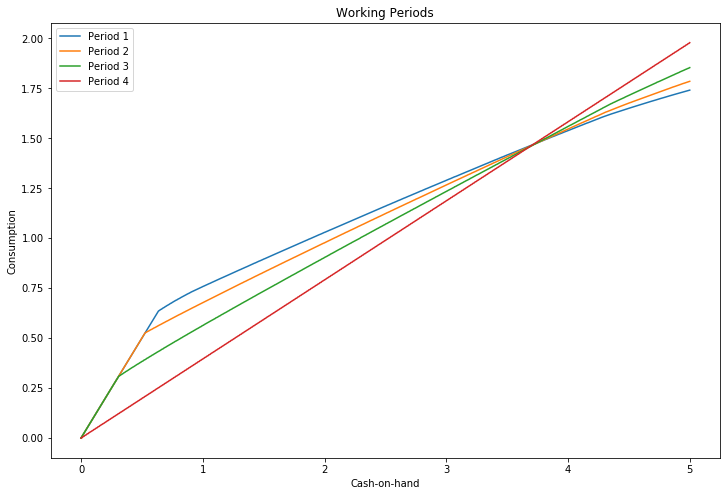

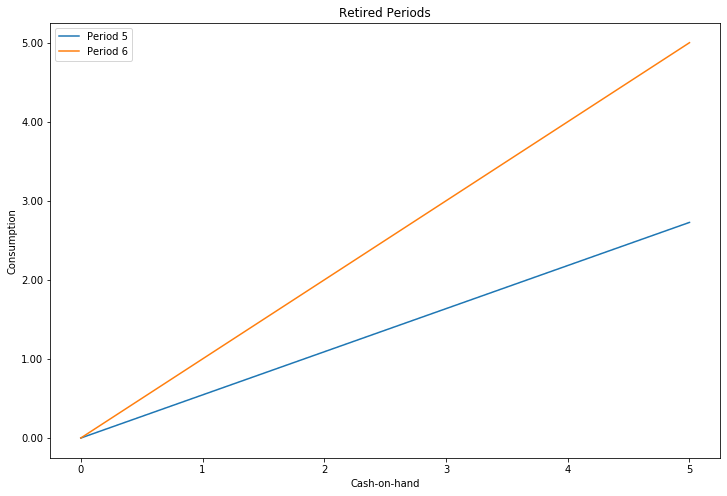

In [3]:
plt.plot(par['𝒢_w'],Cstar[0:par['r'],:].T)
plt.title('Working Periods')
plt.xlabel("Cash-on-hand")
plt.ylabel("Consumption")
plt.gca().legend(('Period 1','Period 2','Period 3','Period 4'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.show()

plt.plot(par['𝒢_w'],Cstar[par['r']:par['T'],:].T)
plt.title('Retired Periods')
plt.xlabel("Cash-on-hand")
plt.ylabel("Consumption")
plt.gca().legend(('Period 5','Period 6'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.show()

For given policy functions, we simulate the model as shown in Model.py:

In [4]:
""" Simulating the model """ 
par['N'] = 100000 # Number of individuals
simW,simA,simC,simY = model.simulation(par,Cstar)

0
1
2
3
4
5


For our simulated results, we plot the profile of average savings over the life-cycle and a sample of individual paths:

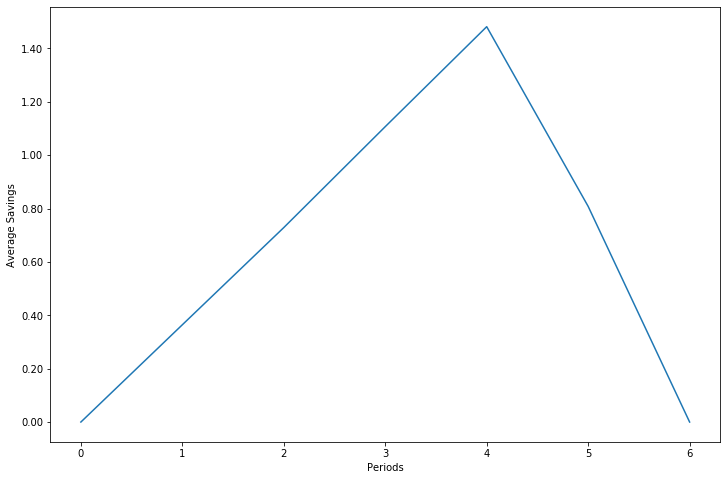

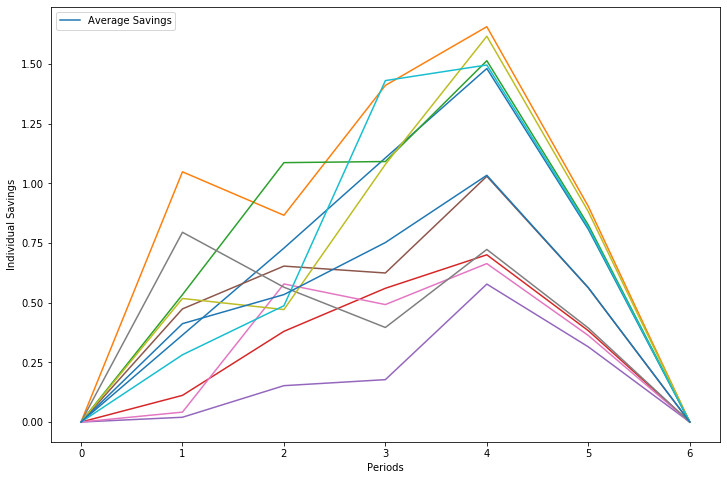

In [5]:
plt.plot(np.mean(simA,axis=1))
plt.xlabel("Periods")
plt.ylabel("Average Savings")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.show()

plt.plot(np.mean(simA,axis=1),label='Average Savings')
plt.legend(loc="upper left")
plt.plot(simA[:,0:10])
plt.xlabel("Periods")
plt.ylabel("Individual Savings")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.show()

## 6. Precautionary Savings
To highlight the importance of risk for saving, we re-run the model with zero risk, but update the mean of the underlying shock process to maintain the same level of average income as in the baseline calibration.

5
4
3
2
1
0


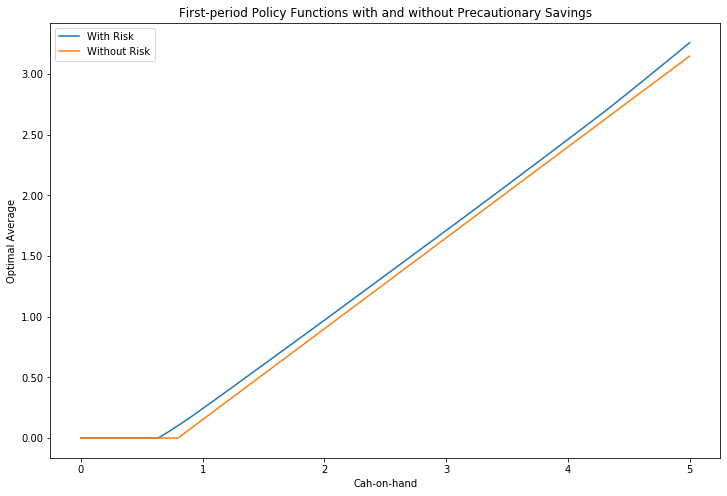

0
1
2
3
4
5


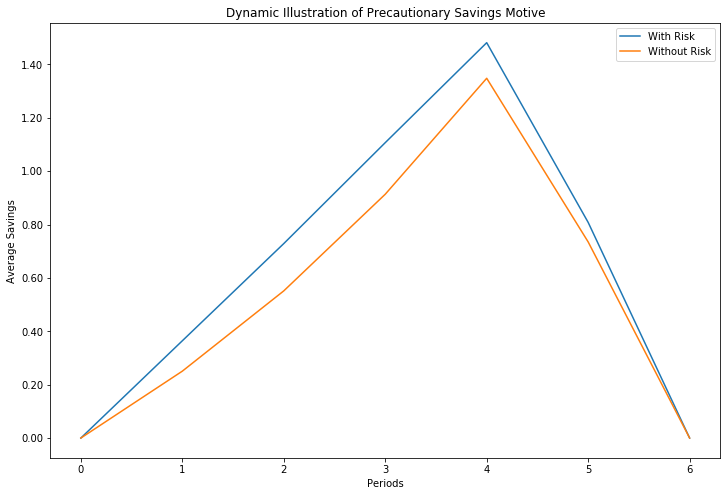

In [6]:
# Restating parameters such that mean is preseved but standard deviation is zero
par['μ'] = par['σ']**2/2
par['σ'] = 0

# Restating the shock vector for deterministic income
par['Y'] = np.repeat(np.exp(par['μ']),par['S'])
par['Y'] = par['Y'].flatten()

# Solving againg
Vstar_nr,Cstar_nr,Astar_nr = model.solve(par)
plt.plot(par['𝒢_w'],Astar[0,:])
plt.plot(par['𝒢_w'],Astar_nr[0,:])
plt.title('First-period Policy Functions with and without Precautionary Savings')
plt.xlabel("Cah-on-hand")
plt.ylabel("Optimal Average")
plt.gca().legend(('With Risk','Without Risk'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.show()

# Simulating again
simW_nr,simA_nr,simC_nr,simY_nr = model.simulation(par,Cstar_nr)
plt.plot(np.mean(simA,axis=1))
plt.plot(np.mean(simA_nr,axis=1))
plt.title('Dynamic Illustration of Precautionary Savings Motive')
plt.xlabel("Periods")
plt.ylabel("Average Savings")
plt.gca().legend(('With Risk','Without Risk'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
plt.show()

# 6. Potential Extensions

1. Mortality Risk
    * Easily done if no uncertainty about future mortality rates
2. A Pension System
    * PAYG
    * FF
3. Persistent/Permanent Income Shocks
    * AR(1)
    * Markov processes
    * Permanent skill types
4. Accidental or Voluntary Bequest
    * Exogenous
    * Endogenous but on aggregate income
    * [Endogenous and family-linked](https://github.com/Frederik-Tim-Econ/OLGLinkedBequest) $\rightarrow$ extra shocks and state variables + convergence of wealth distribution
5. General Equilibrium
    * Convergence of all endogenous distributions
    
Every extension increases computation time! Thus, we could be forced to find more efficient solution methods. This is the topic of Lecture 4.